# Working with fal.ai in Pixeltable

Pixeltable's fal.ai integration enables you to access fal.ai's fast inference models via the fal.ai API.

### Prerequisites

- A fal.ai account with an API key (https://fal.ai/dashboard/keys)

### Important Notes

- fal.ai usage may incur costs based on your fal.ai plan.
- Be mindful of sensitive data and consider security measures when integrating with external services.

First you'll need to install required libraries and enter a fal.ai API key.


In [1]:
%pip install -qU pixeltable fal-client


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import getpass

if 'FAL_API_KEY' not in os.environ:
    os.environ['FAL_API_KEY'] = getpass.getpass('fal.ai API Key: ')


Now let's create a Pixeltable directory to hold the tables for our demo.


In [3]:
import pixeltable as pxt

# Remove the 'fal_demo' directory and its contents, if it exists
pxt.drop_dir('fal_demo', force=True)
pxt.create_dir('fal_demo')


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'fal_demo'.


## Text-to-Image Generation with FLUX Schnell

Let's start by using fal.ai's FLUX Schnell model, which is optimized for fast image generation. We'll create a table to store prompts and generated images.


In [4]:
from pixeltable.functions import fal

# Create a table for image generation
t = pxt.create_table('fal_demo.images', {'prompt': pxt.String})

# Add a computed column that calls the FLUX Schnell model
t.add_computed_column(
    response=fal.run(
        input={'prompt': t.prompt},
        app='fal-ai/flux/schnell'
    )
)


Created table 'images'.
Added 0 column values with 0 errors.


No rows affected.

Now let's insert some prompts and see the results:


In [5]:
# Insert a few prompts
t.insert([
    {'prompt': 'A serene mountain landscape at sunset with a crystal clear lake'},
    {'prompt': 'A friendly robot teaching a class of kittens to code'},
    {'prompt': 'An underwater city with bioluminescent architecture'}
])


Inserting rows into `images`: 0 rows [00:00, ? rows/s]

Inserting rows into `images`: 3 rows [00:00, 283.05 rows/s]


Inserted 3 rows with 0 errors.


3 rows inserted, 6 values computed.

Let's examine the structure of the response:


In [6]:
t.select(t.prompt, t.response).head(1)


prompt,response
A serene mountain landscape at sunset with a crystal clear lake,"{""seed"": 1854926774, ""images"": [{""url"": ""https://v3b.fal.media/files/b/0a84e848/HCSkA3SSrPtEBCczPv_6Z.jpg"", ""width"": 1024, ""height"": 768, ""content_type"": ""image/jpeg""}], ""prompt"": ""A serene mountain landscape at sunset with a crystal clear lake"", ""timings"": {""inference"": 0.143}, ""has_nsfw_concepts"": [false]}"


We can see that fal.ai returns a JSON response with an `images` array. Each image has a `url` field. Let's extract and display the images:


Added 3 column values with 0 errors.


prompt,image
A serene mountain landscape at sunset with a crystal clear lake,
A friendly robot teaching a class of kittens to code,
An underwater city with bioluminescent architecture,

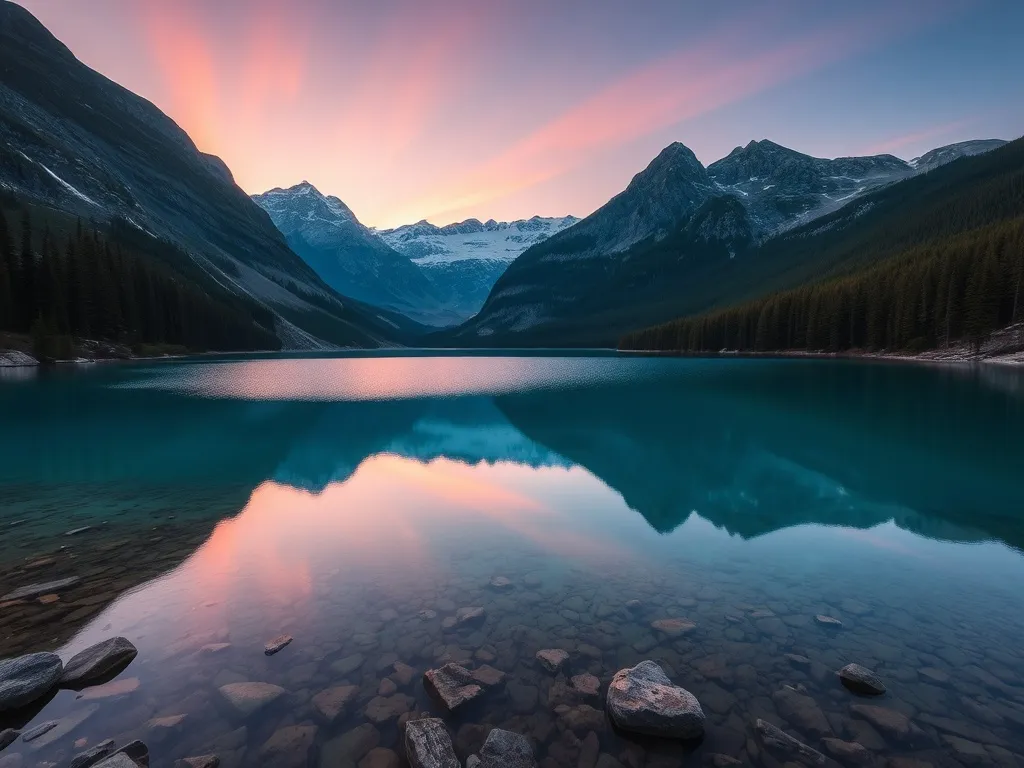
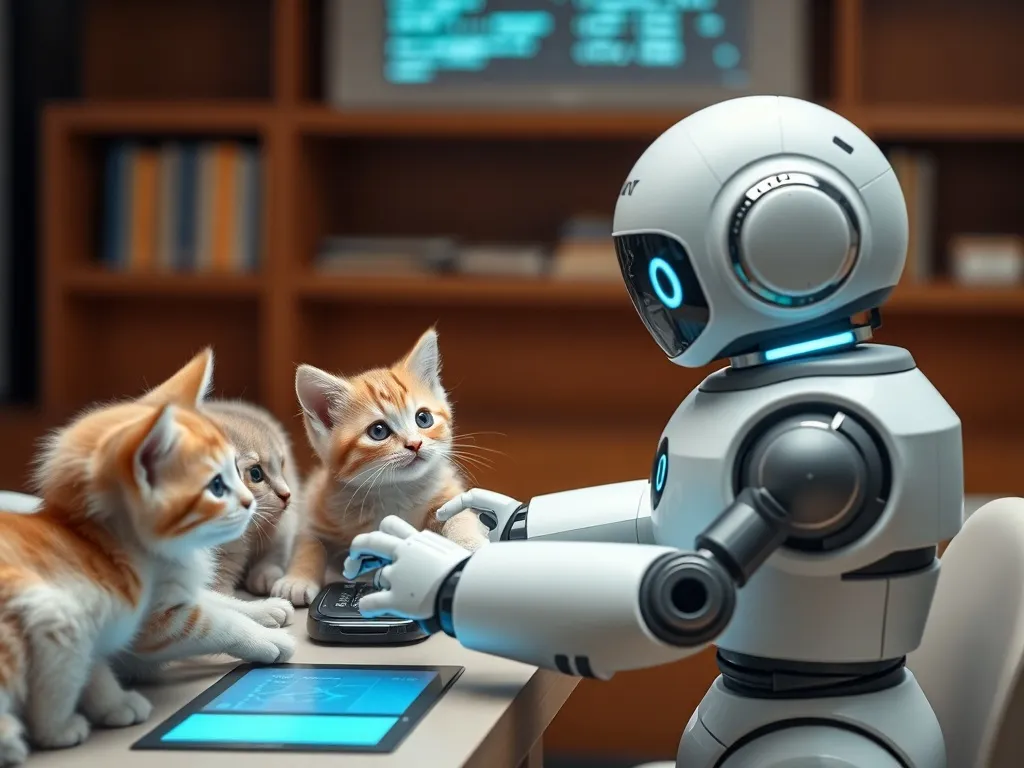
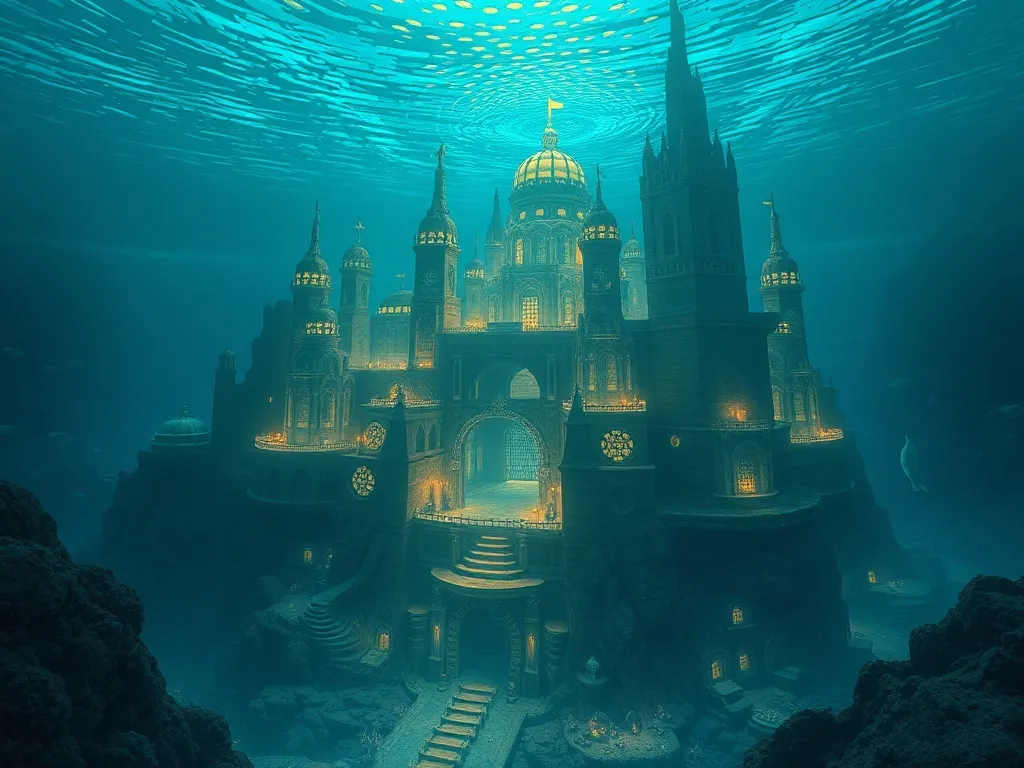

In [7]:
# Add a computed column to extract the image URL and convert it to an Image type
t.add_computed_column(image=t.response['images'][0]['url'].astype(pxt.Image))

# Display the prompts and images
t.select(t.prompt, t.image).head()


## Advanced Image Generation with Fast SDXL

fal.ai also offers Fast SDXL, which provides more control over image generation parameters. Let's create a new table to explore these capabilities.


In [8]:
# Create a table with more parameters
sdxl_t = pxt.create_table(
    'fal_demo.sdxl_images',
    {
        'prompt': pxt.String,
        'negative_prompt': pxt.String,
        'steps': pxt.Int
    }
)

# Add a computed column with more parameters
sdxl_t.add_computed_column(
    response=fal.run(
        input={
            'prompt': sdxl_t.prompt,
            'negative_prompt': sdxl_t.negative_prompt,
            'image_size': 'square_hd',  # 1024x1024
            'num_inference_steps': sdxl_t.steps
        },
        app='fal-ai/fast-sdxl'
    )
)

# Extract the image
sdxl_t.add_computed_column(image=sdxl_t.response['images'][0]['url'].astype(pxt.Image))


Created table 'sdxl_images'.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


No rows affected.

In [9]:
# Insert prompts with different parameters
sdxl_t.insert([
    {
        'prompt': 'A majestic lion in a savanna at golden hour, photorealistic',
        'negative_prompt': 'cartoon, illustration, drawing',
        'steps': 25
    },
    {
        'prompt': 'A futuristic cityscape with flying cars and neon lights',
        'negative_prompt': 'blurry, low quality',
        'steps': 30
    }
])


Inserting rows into `sdxl_images`: 0 rows [00:00, ? rows/s]

Inserting rows into `sdxl_images`: 2 rows [00:00, 325.95 rows/s]


Inserted 2 rows with 0 errors.


2 rows inserted, 8 values computed.

prompt,image
"A majestic lion in a savanna at golden hour, photorealistic",
A futuristic cityscape with flying cars and neon lights,

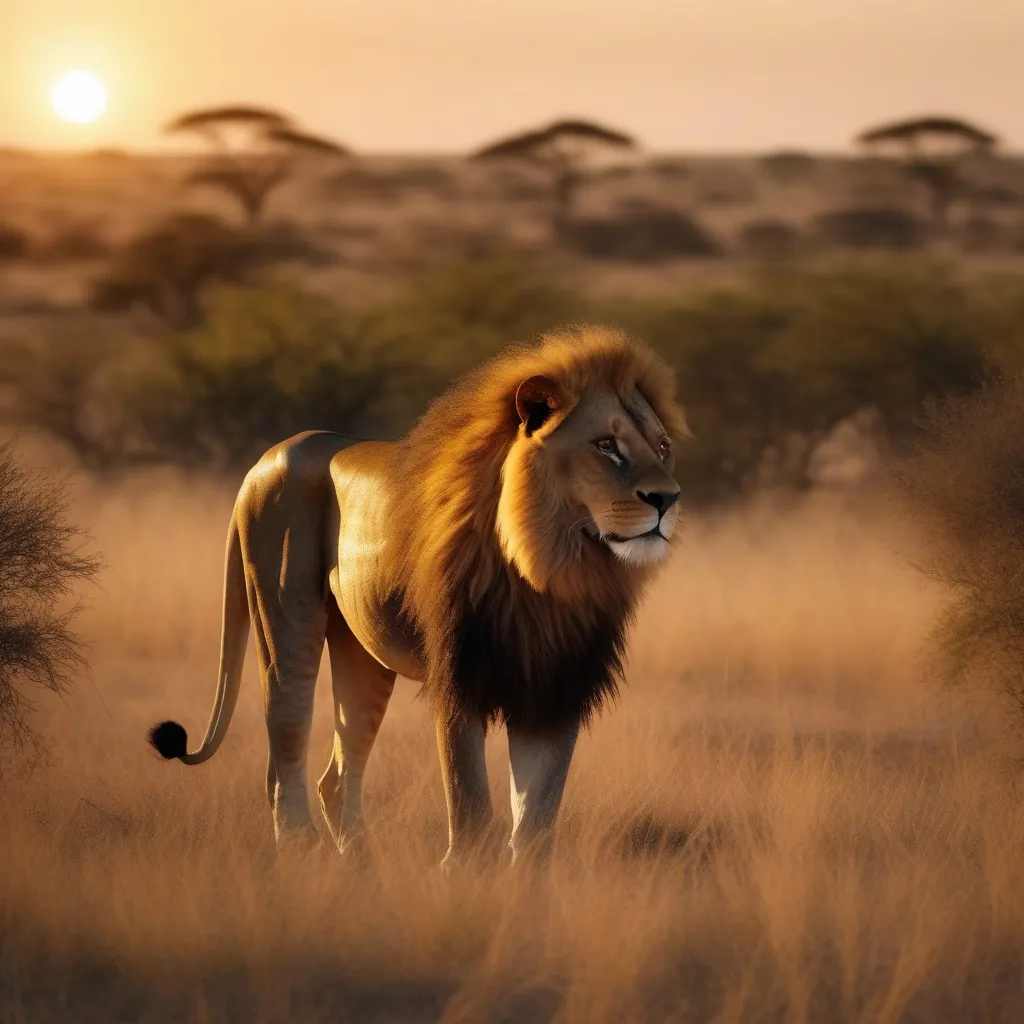
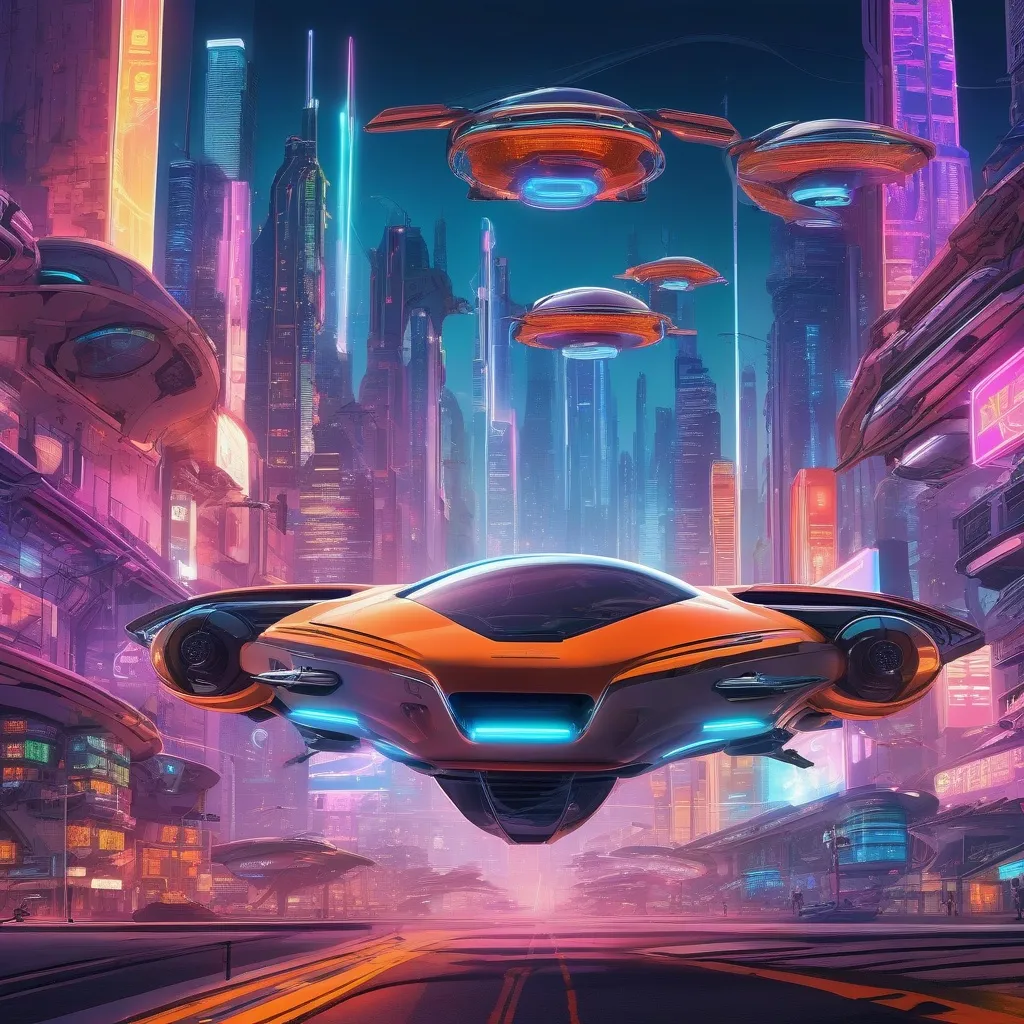

In [10]:
# Display the results
sdxl_t.select(sdxl_t.prompt, sdxl_t.image).head()


## Generating Multiple Images per Prompt

You can also generate multiple variations of the same prompt in a single request:


In [11]:
# Create a table for multiple image generation
multi_t = pxt.create_table('fal_demo.multi_images', {'prompt': pxt.String})

# Generate 3 variations of each prompt
multi_t.add_computed_column(
    response=fal.run(
        input={
            'prompt': multi_t.prompt,
            'num_images': 3
        },
        app='fal-ai/flux/schnell'
    )
)

# Extract the first image (you could create columns for all three)
multi_t.add_computed_column(image_1=multi_t.response['images'][0]['url'].astype(pxt.Image))
multi_t.add_computed_column(image_2=multi_t.response['images'][1]['url'].astype(pxt.Image))
multi_t.add_computed_column(image_3=multi_t.response['images'][2]['url'].astype(pxt.Image))


Created table 'multi_images'.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


No rows affected.

In [12]:
# Insert a prompt
multi_t.insert([{'prompt': 'A steampunk mechanical butterfly on a brass flower'}])


Inserting rows into `multi_images`: 0 rows [00:00, ? rows/s]

Inserting rows into `multi_images`: 1 rows [00:00, 607.25 rows/s]


Inserted 1 row with 0 errors.


1 row inserted, 5 values computed.

image_1,image_2,image_3
,,

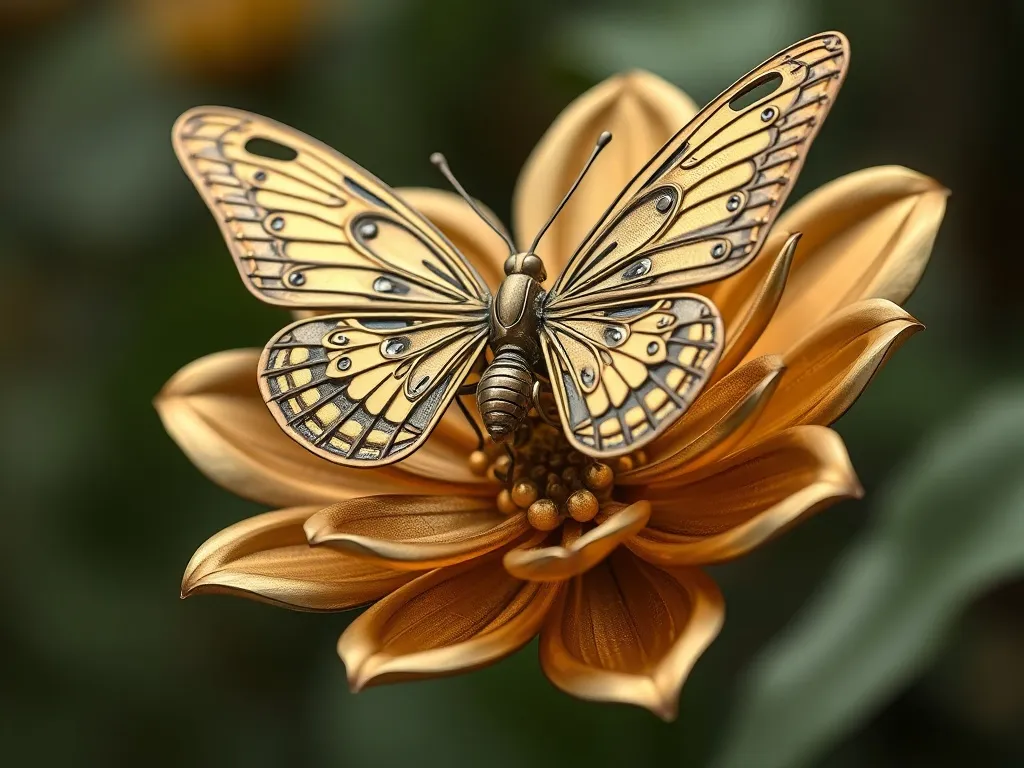
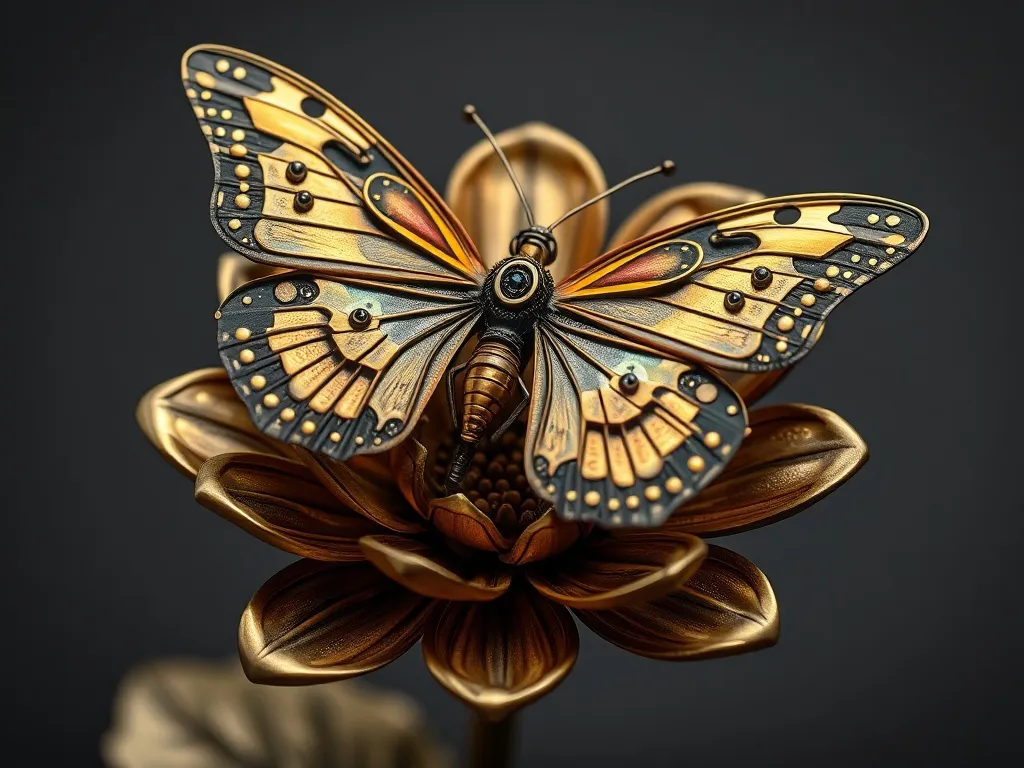
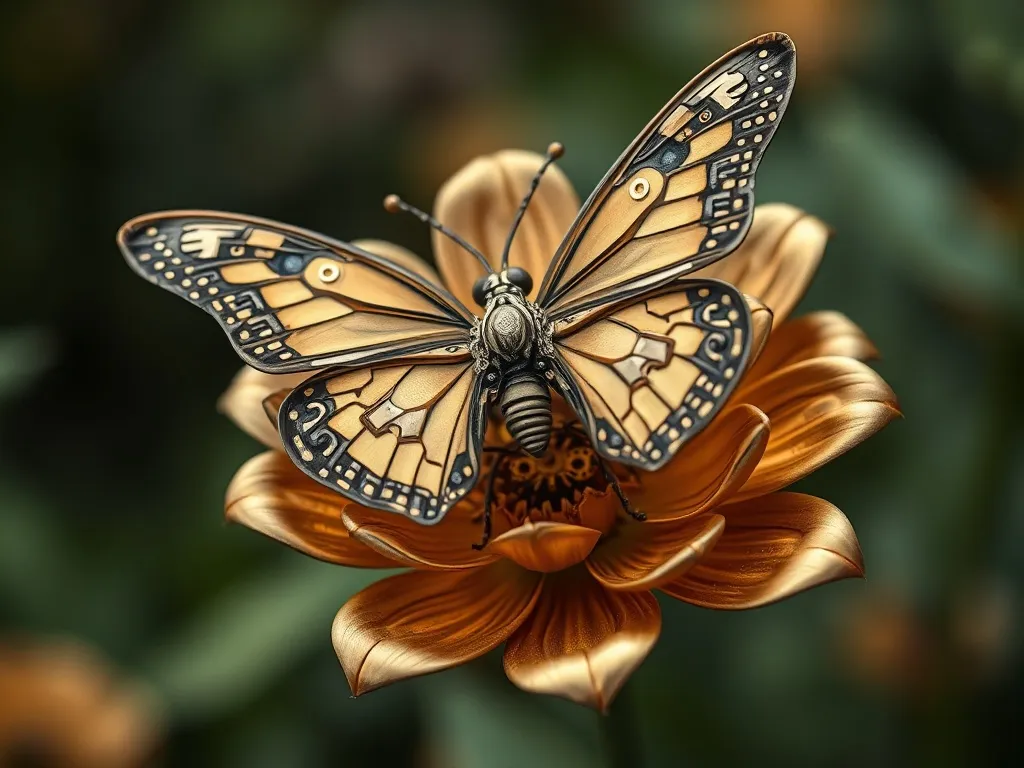

In [13]:
# Display all three variations
multi_t.select(multi_t.image_1, multi_t.image_2, multi_t.image_3).head()


## Using Higher Quality Models

For higher quality generation, you can use models like `fal-ai/flux/dev` which produce better results but take more time:


In [14]:
# Create a table using FLUX Dev
dev_t = pxt.create_table('fal_demo.flux_dev', {'prompt': pxt.String})

# Use FLUX Dev model for higher quality
dev_t.add_computed_column(
    response=fal.run(
        input={'prompt': dev_t.prompt},
        app='fal-ai/flux/dev'
    )
)

dev_t.add_computed_column(image=dev_t.response['images'][0]['url'].astype(pxt.Image))


Created table 'flux_dev'.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


No rows affected.

In [15]:
# Insert a prompt (note: FLUX Dev may take longer but produces higher quality results)
dev_t.insert([{'prompt': 'A highly detailed oil painting of a wizard casting a spell in an ancient library'}])


Inserting rows into `flux_dev`: 0 rows [00:00, ? rows/s]

Inserting rows into `flux_dev`: 1 rows [00:00, 588.26 rows/s]


Inserted 1 row with 0 errors.


1 row inserted, 3 values computed.

prompt,image
A highly detailed oil painting of a wizard casting a spell in an ancient library,

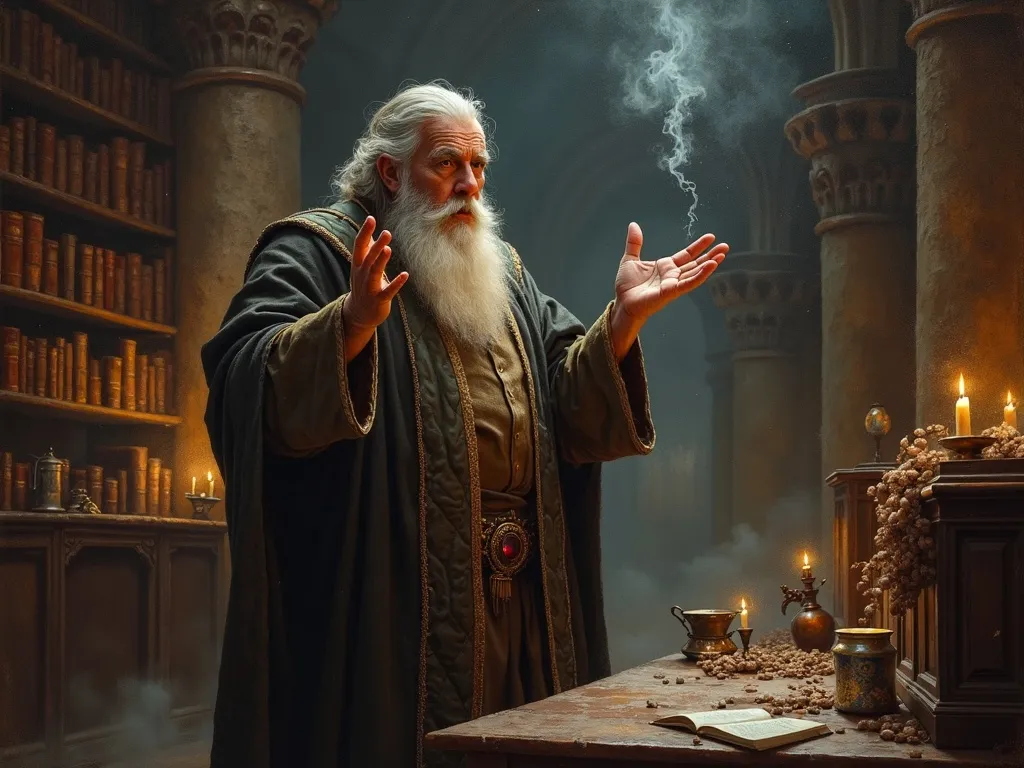

In [16]:
# Display the result
dev_t.select(dev_t.prompt, dev_t.image).head()


## Exploring Available Models

fal.ai offers a wide variety of models. Here are some popular ones you can try:

### Image Generation Models
- `fal-ai/flux/schnell` - Fast FLUX model for quick image generation
- `fal-ai/flux/dev` - Higher quality FLUX model (slower)
- `fal-ai/fast-sdxl` - Fast Stable Diffusion XL
- `fal-ai/stable-diffusion-v3-medium` - Stable Diffusion 3 Medium

### Other Models
- `fal-ai/fast-lightning-sdxl` - Ultra-fast SDXL variant
- `fal-ai/recraft-v3` - Recraft V3 for design-focused generation

To use a different model, simply change the `app` parameter in your `fal.run()` call.


## Working with Batch Processing

Pixeltable's computed columns make it easy to process multiple images in batch. Let's create a larger dataset:


In [17]:
# Create a batch processing table
batch_t = pxt.create_table('fal_demo.batch', {'category': pxt.String, 'description': pxt.String})

# Create a prompt by combining category and description
batch_t.add_computed_column(
    prompt=pxt.functions.string.format('A {} that is {}', batch_t.category, batch_t.description)
)

# Generate images
batch_t.add_computed_column(
    response=fal.run(
        input={'prompt': batch_t.prompt},
        app='fal-ai/flux/schnell'
    )
)

batch_t.add_computed_column(image=batch_t.response['images'][0]['url'].astype(pxt.Image))


Created table 'batch'.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


No rows affected.

In [18]:
# Insert a batch of prompts
batch_t.insert([
    {'category': 'landscape', 'description': 'peaceful and zen-like'},
    {'category': 'portrait', 'description': 'mysterious and ethereal'},
    {'category': 'abstract art', 'description': 'colorful and energetic'},
    {'category': 'architecture', 'description': 'modern and minimalist'},
    {'category': 'animal', 'description': 'cute and fluffy'}
])


Inserting rows into `batch`: 0 rows [00:00, ? rows/s]

Inserting rows into `batch`: 5 rows [00:00, 1753.76 rows/s]


Inserted 5 rows with 0 errors.


5 rows inserted, 30 values computed.

category,description,image
landscape,peaceful and zen-like,
animal,cute and fluffy,
architecture,modern and minimalist,
abstract art,colorful and energetic,
portrait,mysterious and ethereal,

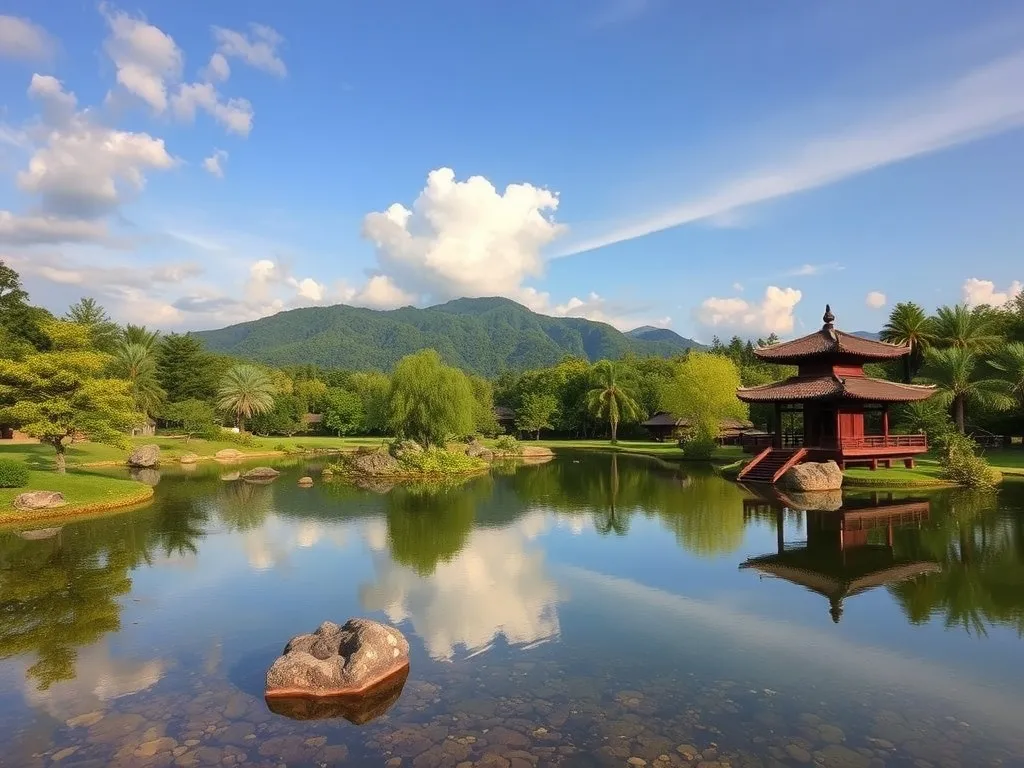
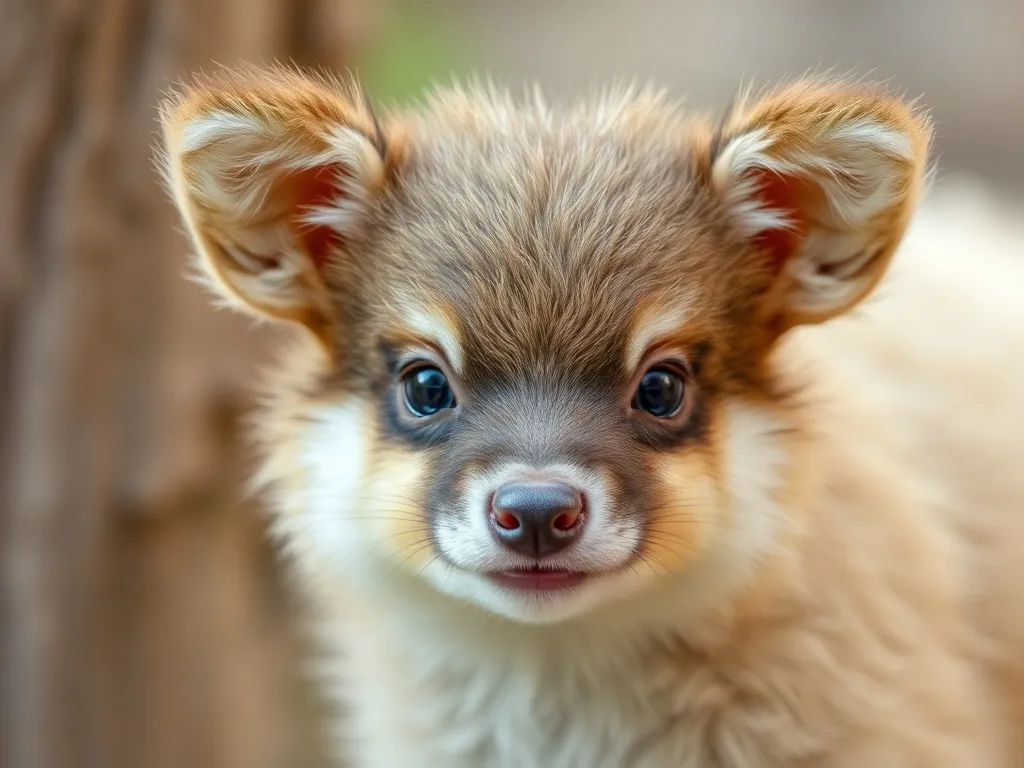
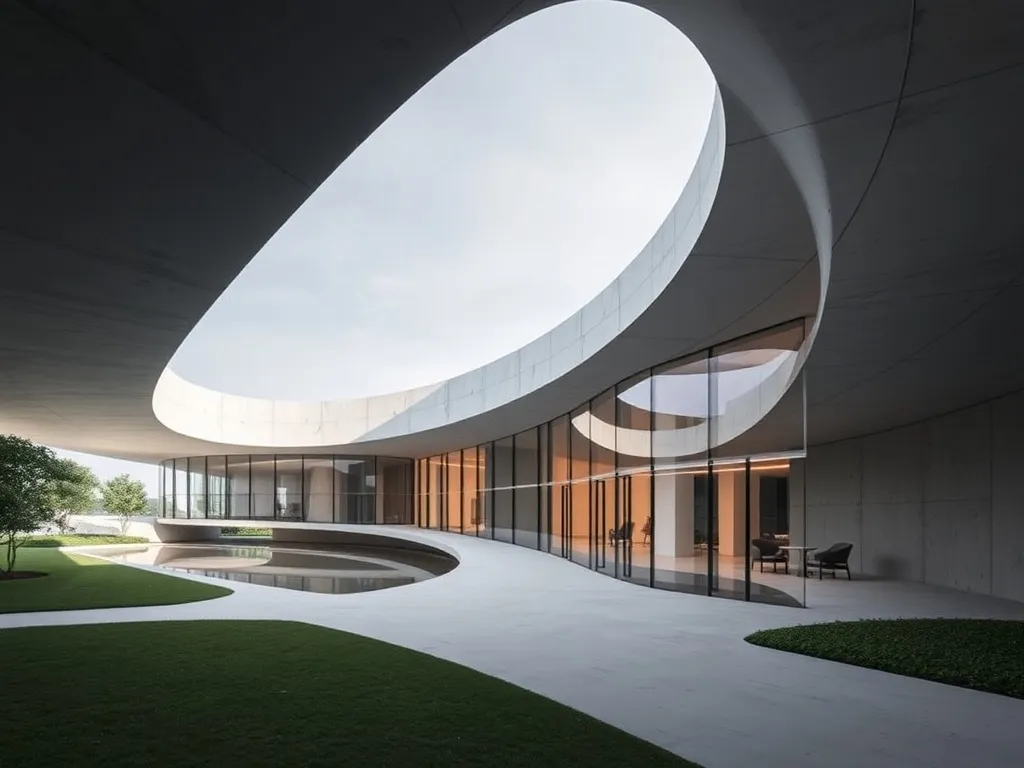
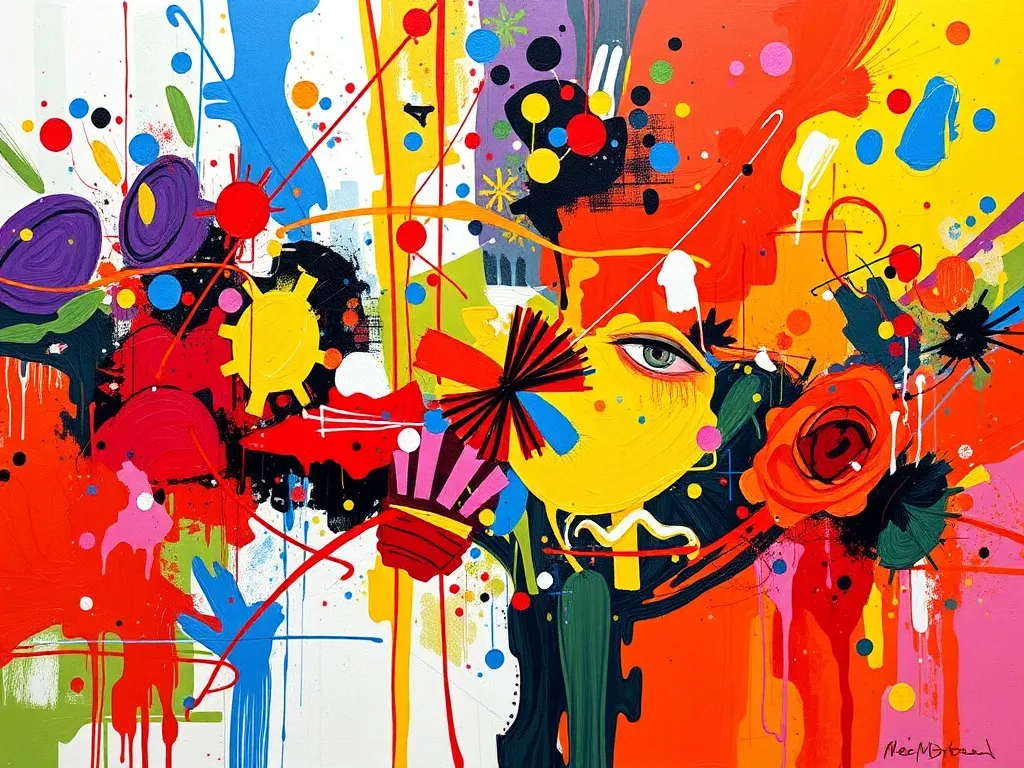
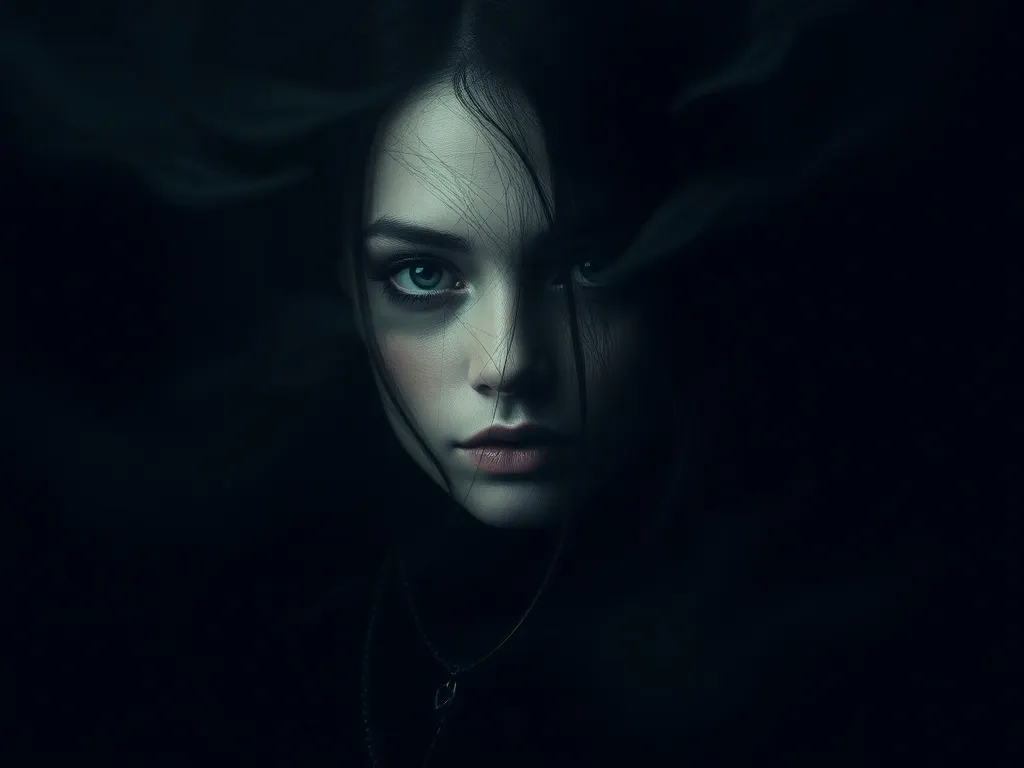

In [19]:
# View all results
batch_t.select(batch_t.category, batch_t.description, batch_t.image).show()


## Tips and Best Practices

1. **Rate Limiting**: fal.ai has rate limits. Pixeltable respects these limits by default. You can configure custom rate limits in your Pixeltable config.

2. **Model Selection**: 
   - Use `flux/schnell` for fast prototyping and when speed is critical
   - Use `flux/dev` when you need higher quality and can afford longer generation times
   - Use `fast-sdxl` for a good balance of speed and quality

3. **Prompt Engineering**: Good prompts lead to better results. Be specific and descriptive.

4. **Negative Prompts**: Use negative prompts to exclude unwanted elements from your images.

5. **Caching**: Pixeltable automatically caches results, so re-running the same prompt won't incur additional costs.

### Learn More

- fal.ai Documentation: https://fal.ai/docs
- Pixeltable Documentation: https://docs.pixeltable.com
- To learn more about advanced techniques like RAG operations in Pixeltable, check out the [RAG Operations in Pixeltable](https://docs.pixeltable.com/notebooks/use-cases/rag-operations) tutorial.

If you have any questions, don't hesitate to reach out on our [Discord community](https://pixeltable.com/discord)!
